<a href="https://colab.research.google.com/github/Chutki319239/msazure/blob/main/copy_of_Dissertation_PD_revised_afterchangein_Regnety600.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
# After installation is complete you must restart the notebook otherwise you
# will face some import errors
!pip install imutils
!pip install super_gradients==3.0.7
!pip install albumentations
!pip install split-folders[full]

In [ ]:
!pip install super-gradients

In [ ]:
import os
import math
import random
from typing import Dict, List,Tuple
import requests
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path, PurePath
import pathlib
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from imutils import paths
import splitfolders
import textwrap
import super_gradients
from super_gradients.common.object_names import Models
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams
from super_gradients.training.metrics.classification_metrics import Accuracy, Top5
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training import models
from super_gradients.training.utils.callbacks import Phase

In [ ]:
!cd .. && mkdir input

mkdir: cannot create directory ‘input’: File exists


In [ ]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token

mkdir: cannot create directory ‘input’: File exists


KeyboardInterrupt: 

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat './kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d srisaivpravallika22/pd-ntua
!mv pd-ntua.zip ../input
!cd ../input && unzip pd-ntua.zip


Dataset URL: https://www.kaggle.com/datasets/srisaivpravallika22/pd-ntua
License(s): apache-2.0
 97% 490M/503M [00:03<00:00, 166MB/s]
100% 503M/503M [00:03<00:00, 142MB/s]
Archive:  pd-ntua.zip
replace MRI/non_pd/3D_Brain_FLAIR_001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from pathlib import Path

def count_subdirectories(path: str) -> int:
    """
    Counts the number of subdirectories in the given directory path.
    """
    dir_path = Path(path)
    subdirectories = [f for f in dir_path.iterdir() if f.is_dir()]
    return len(subdirectories)

# Example usage
parent_dir = "../input/MRI"
num_subdirectories = count_subdirectories(parent_dir)
print(f"Number of subdirectories in {parent_dir}: {num_subdirectories}")

Number of subdirectories in ../input/MRI: 2


In [ ]:
class config:
    # specify the paths to datasets
    DOWNLOAD_DIR = Path('../input/MRI')
    ROOT_DIR = Path('content')
    TRAIN_DIR = ROOT_DIR.joinpath('train')
    TEST_DIR = ROOT_DIR.joinpath('test')
    VAL_DIR = ROOT_DIR.joinpath('val')

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    # set the input heig/ht and width
    IMAGENET_MEAN = [0.50, 0.50, 0.50]
    IMAGENET_STD = [0.50, 0.50, 0.50]

    IMAGE_TYPE = '.jpg'
    BATCH_SIZE = 32
    MODEL_NAME = 'regnetY600'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TRAINING_PARAMS = 'training_hyperparams/default_train_params'

    NUM_CLASSES = num_subdirectories

    CHECKPOINT_DIR = 'checkpoints'

In [ ]:
#Split data into training, validation and testing sets.

splitfolders.ratio(config.DOWNLOAD_DIR, output=config.ROOT_DIR, seed=42, ratio=(.8, .1, .1), group_prefix=None, move=False)



Copying files: 10671 files [00:15, 688.72 files/s] 


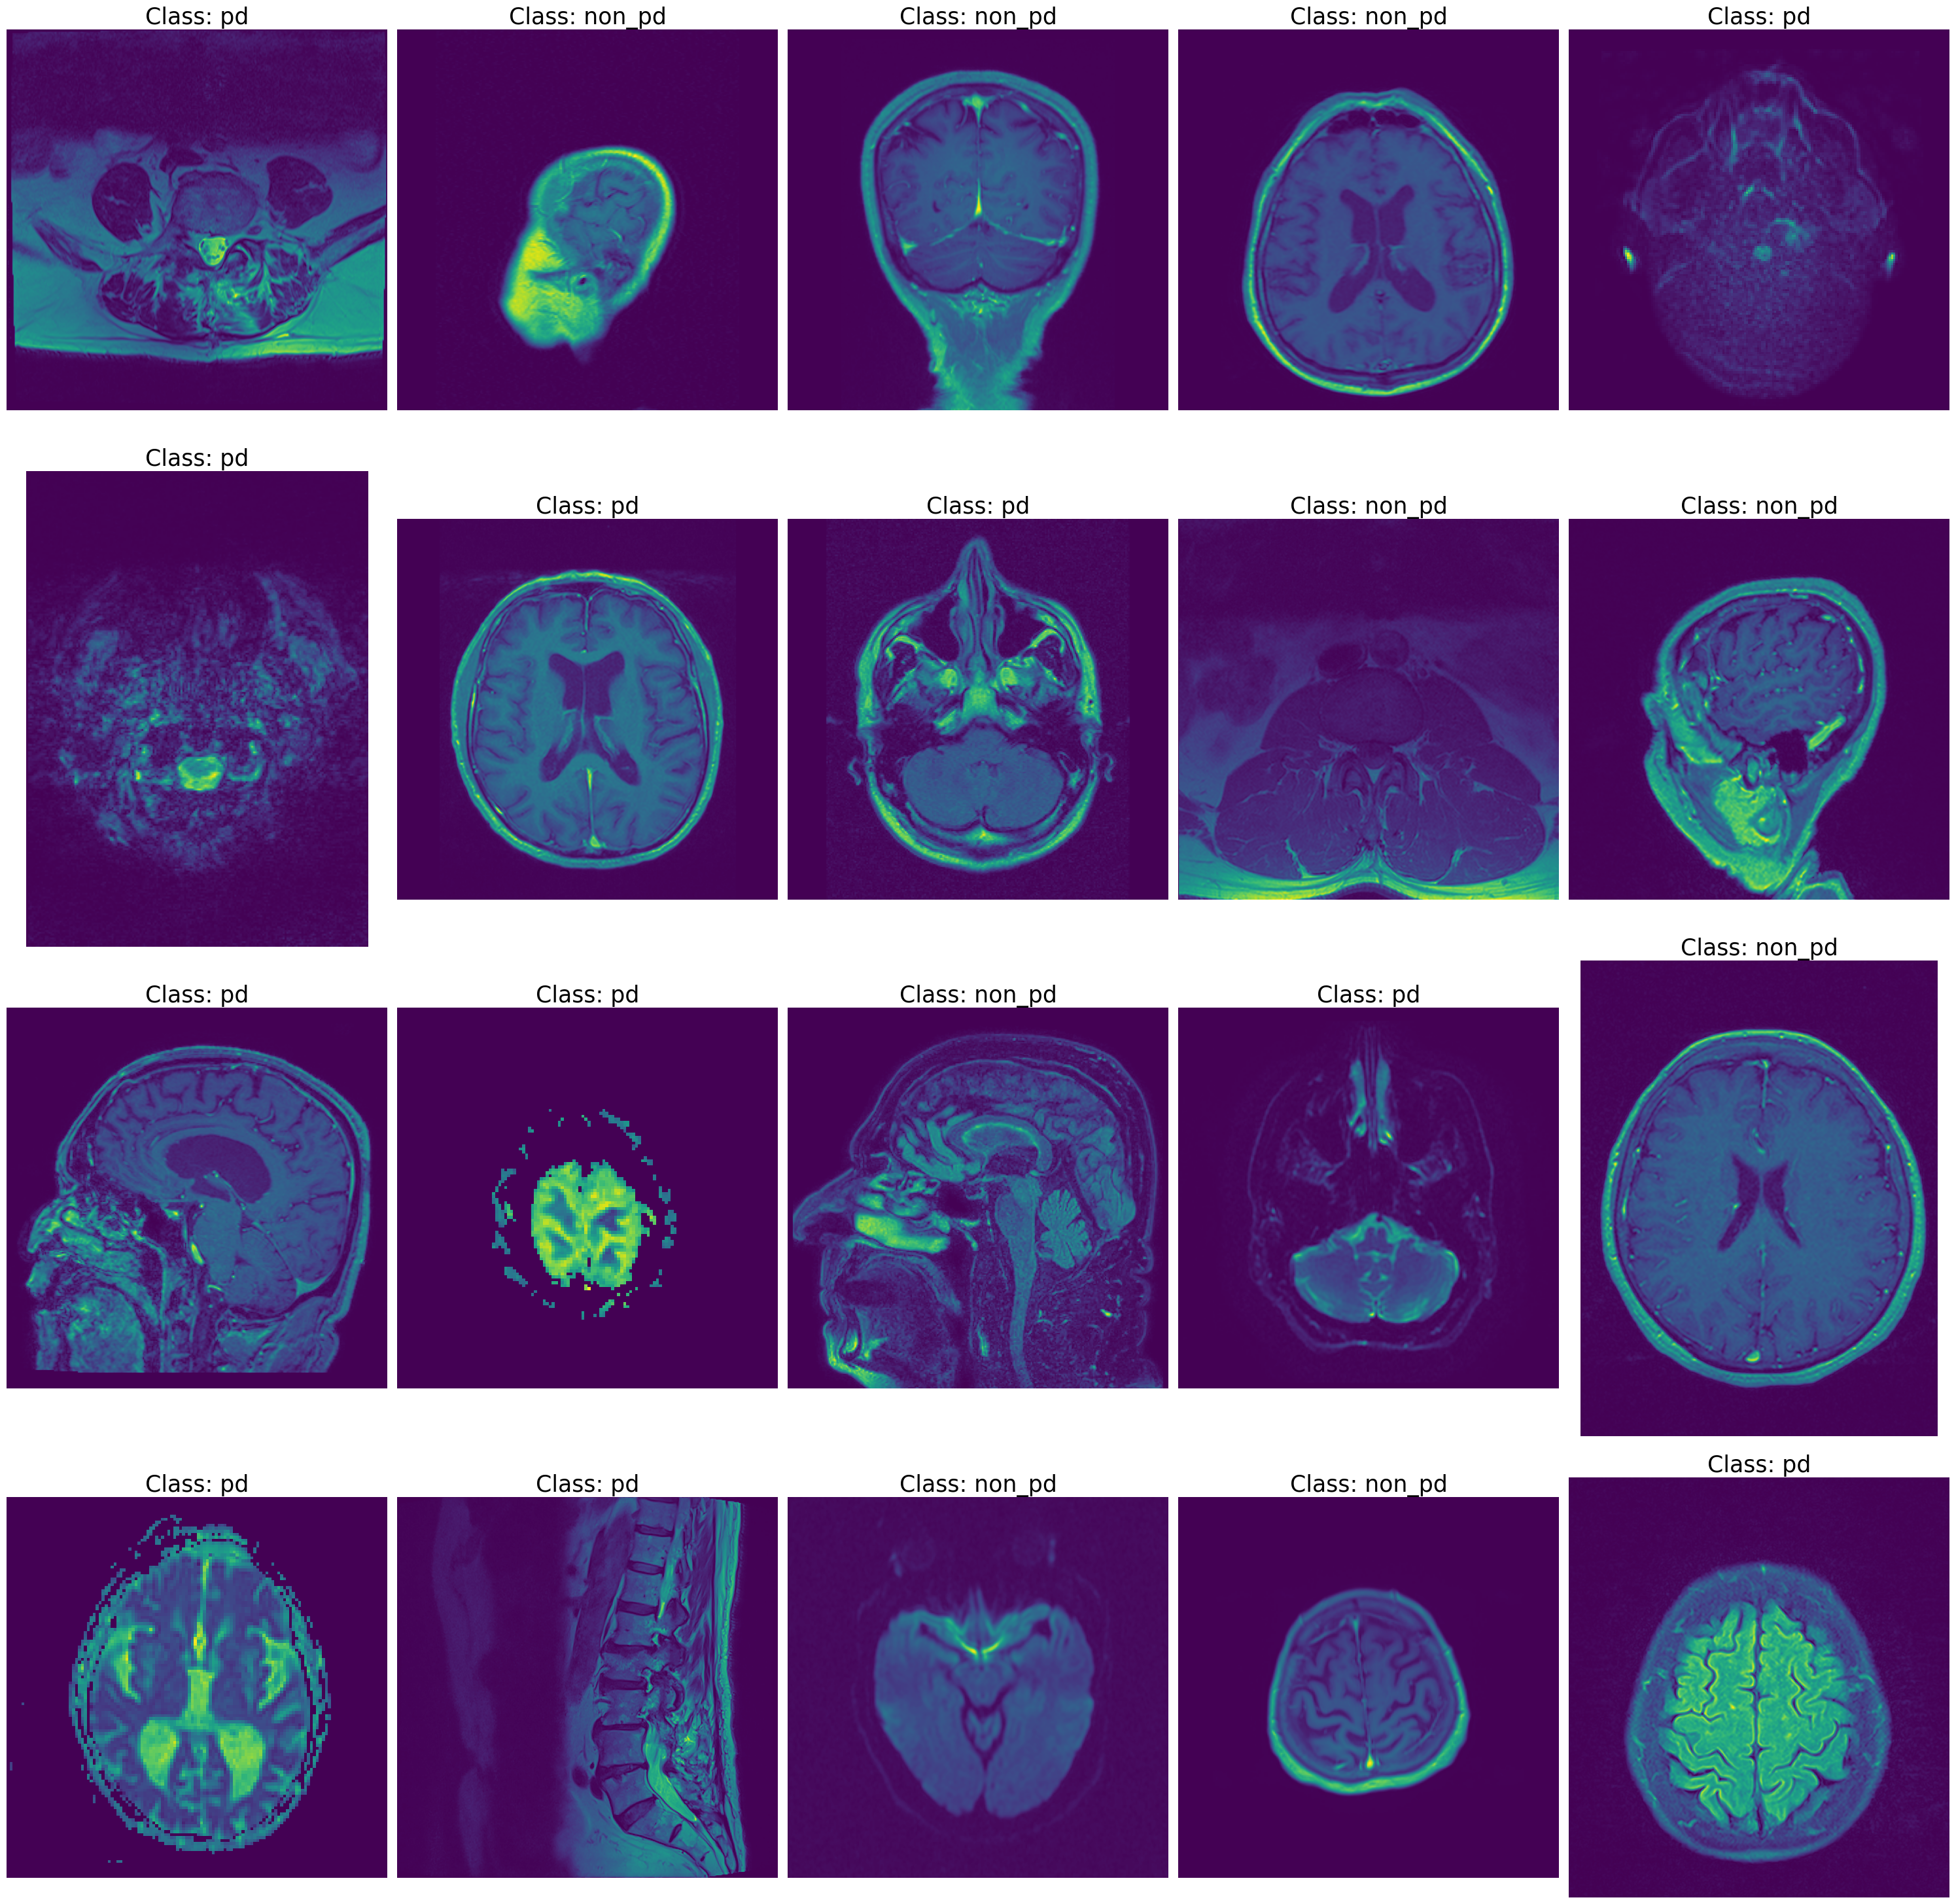

In [ ]:
#Plot random images
train_image_path_list = list(sorted(paths.list_images(config.TRAIN_DIR)))
train_image_path_sample = random.sample(population=train_image_path_list, k=20)

def examine_images(images:list):
    num_images = len(images)
    num_rows = int(math.ceil(num_images/5))
    num_cols = 5

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30),tight_layout=True)
    axs = axs.ravel()

    for i, image_path in enumerate(images[:num_images]):
        image = Image.open(image_path)
        label = PurePath(image_path).parent.name
        axs[i].imshow(image)
        axs[i].set_title(f"Class: {label}", fontsize=25)
        axs[i].axis('off')
    plt.show()

examine_images(train_image_path_sample)


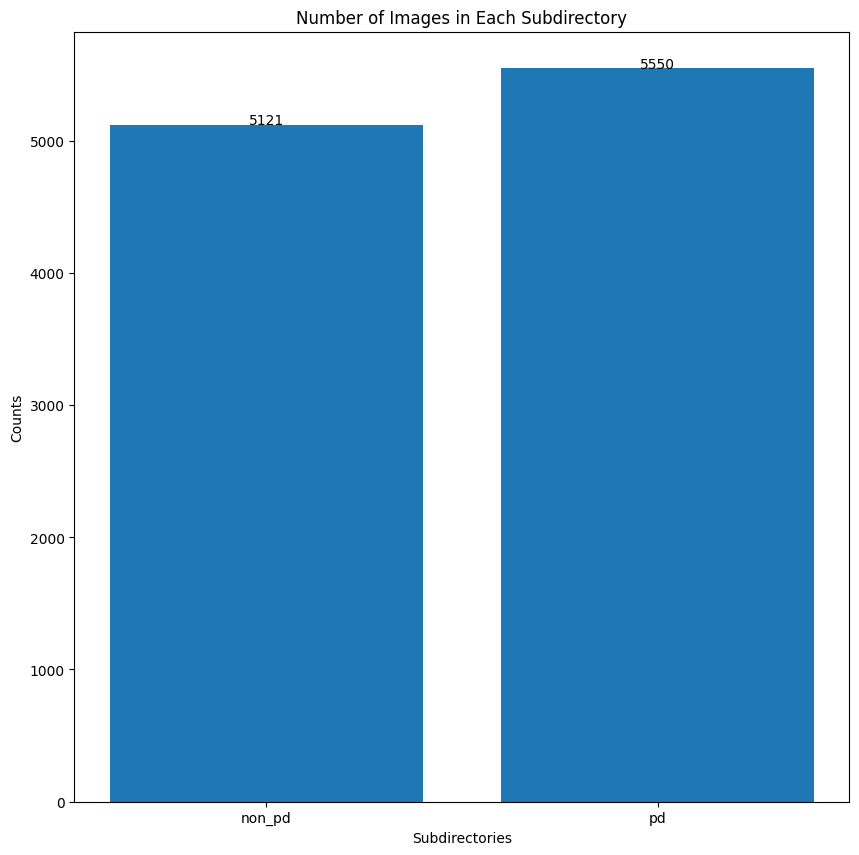

In [ ]:
#Check for class distribution
# Get a list of all subdirectories in the root directory
subdirs = [d for d in Path(config.DOWNLOAD_DIR).iterdir() if d.is_dir()]

image_count = {}

# Iterate through each subdirectory
for subdir in subdirs:
    subdir_images = list(sorted(paths.list_images(subdir)))
    image_count[subdir.name] = len(subdir_images)

# create a new figure with desired size
fig = plt.figure(figsize=(10, 10))

plt.bar(image_count.keys(), image_count.values())
# add the count numbers on top of the bars
for i, (subdir, count) in enumerate(image_count.items()):
    plt.text(i, count + 3, str(count), ha='center')

# set the title and labels for the plot
plt.title("Number of Images in Each Subdirectory")
plt.xlabel("Subdirectories")
plt.ylabel("Counts")

# show the plot
plt.show()


In [ ]:
#Check image mode
image_types = {'path': [], 'mode': []}
# loop over all image files in the root directory and its subdirectories
for file_path in paths.list_images(config.ROOT_DIR):
    # open the image using PIL and get its mode
    with Image.open(file_path) as img:
        image_types['path'].append(file_path)
        image_types['mode'].append(img.mode)

# create a dataframe from the data
image_types_df = pd.DataFrame(image_types)
image_types_df['mode'].value_counts()

mode
L    10671
Name: count, dtype: int64

In [ ]:
def convert_l_to_rgb(image_path):
  img = Image.open(image_path)
  rgb_img = Image.merge('RGB', (img, img, img))
  rgb_img.save(image_path)

# Loop over all image paths in the dataframe and convert if needed
for index, row in image_types_df.iterrows():
    if row['mode'] == 'L':
        convert_l_to_rgb(row['path'])


In [ ]:
#Augmentations
# initialize our data augmentation functions
resize = transforms.Resize(size=(config.INPUT_HEIGHT,config.INPUT_WIDTH))
make_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
center_cropper = transforms.CenterCrop((config.INPUT_HEIGHT,config.INPUT_WIDTH))
random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.75)
random_vertical_flip = transforms.RandomVerticalFlip(p=0.75)
random_rotation = transforms.RandomRotation(degrees=90)
random_crop = transforms.RandomCrop(size=(200,200))
augmix = transforms.AugMix(severity = 3, mixture_width=3, alpha=1.0)
auto_augment = transforms.AutoAugment()
random_augment = transforms.RandAugment()
#elastic_transformer = transforms.ElasticTransform(alpha=65.0)

elastic_transformer = transforms.ElasticTransform(alpha=50.0, sigma=5.0,fill=0)

# initialize our training and validation set data augmentation pipeline
train_transforms = transforms.Compose([
  resize,
  elastic_transformer,
  # auto_augment,
  random_augment,
  make_tensor,
  normalize
])

val_transforms = transforms.Compose([resize, make_tensor, normalize])

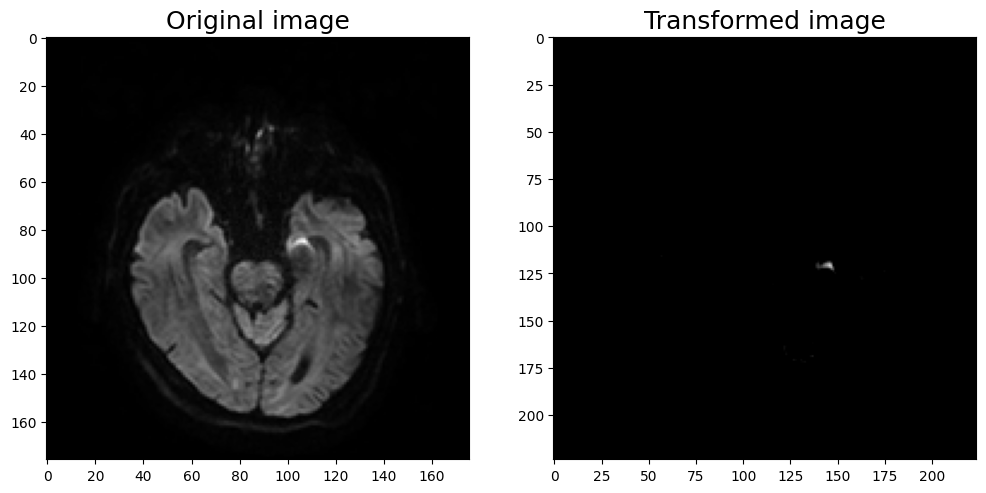

In [ ]:
#Show what one image looks like after augmentation
def apply_transform(img: Image, transform) -> np.ndarray:
    """
    Applies a transform to a PIL Image and returns a numpy array of the transformed image.

    Args:
        img (PIL.Image): The input image to transform.
        transform (torchvision.transforms.Compose): The transform to apply to the image.

    Returns:
        np.ndarray: A numpy array representing the transformed image.
    """
    # Apply the transform to the image
    if isinstance(transform, torchvision.transforms.Compose):
        # Apply PyTorch transform to image array
        transformed_image = train_transforms(img)

    elif isinstance(transform, A.Compose):
        # Apply Albumentations transform to image array
        img_array = np.array(img)
        transformed_image = transform(image=img_array)["image"]

    # Convert the image tensor to a numpy array and transpose the axes to (height, width, channels)
    img_array = transformed_image.numpy().transpose((1, 2, 0))

    # Clip the pixel values to the range [0, 1]
    img_array = np.clip(img_array, 0, 1)

    return img_array


def visualize_transform(image: np.ndarray, original_image: np.ndarray = None) -> None:
    """
    Visualize the transformed image.

    Args:
        image (np.ndarray): A NumPy array representing the transformed image.
        original_image (np.ndarray, optional): A NumPy array representing the original image. Defaults to None.
    """
    fontsize = 18

    if original_image is None:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the transformed image in the first column.
        ax[0].imshow(image)
    else:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the original image in the first column.
        ax[0].imshow(original_image)
        ax[0].set_title('Original image', fontsize=fontsize)

        # Show the transformed image in the second column.
        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

img = Image.open(random.choice(train_image_path_list))
img_array = apply_transform(img, train_transforms)
visualize_transform(img_array, original_image=img)

In [ ]:
#Datasets and Dataloader
def create_dataloaders(
    train_dir: str,
    val_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    val_transform:  transforms.Compose,
    test_transform:  transforms.Compose,
    batch_size: int,
    num_workers: int=2
):
  """Creates training and validation DataLoaders.
  Args:
    train_dir: Path to training data.
    val_dir: Path to validation data.
    transform: Transformation pipeline.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, val_dataloader, class_names).
  """
  # Use ImageFolder to create dataset
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  val_data = datasets.ImageFolder(val_dir, transform=val_transform)
  test_data = datasets.ImageFolder(test_dir, transform=val_transform)

  print(f"[INFO] training dataset contains {len(train_data)} samples...")
  print(f"[INFO] validation dataset contains {len(val_data)} samples...")
  print(f"[INFO] test dataset contains {len(test_data)} samples...")

  # Get class names
  class_names = train_data.classes
  print(f"[INFO] dataset contains {len(class_names)} labels...")

  # Turn images into data loaders
  print("[INFO] creating training and validation set dataloaders...")
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      drop_last=True,
      num_workers=num_workers,
      pin_memory=True,
      persistent_workers=True
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=config.TRAIN_DIR,
                                                                     val_dir=config.VAL_DIR,
                                                                     test_dir=config.TEST_DIR,
                                                                     train_transform=train_transforms,
                                                                     val_transform=val_transforms,
                                                                     test_transform=val_transforms,
                                                                     batch_size=config.BATCH_SIZE)

NUM_CLASSES = len(class_names)


[INFO] training dataset contains 8536 samples...
[INFO] validation dataset contains 1067 samples...
[INFO] test dataset contains 1068 samples...
[INFO] dataset contains 2 labels...
[INFO] creating training and validation set dataloaders...


In [ ]:
#Training Params
training_params =  training_hyperparams.get(config.TRAINING_PARAMS)


In [ ]:
# To reduce clutter in the notebook I've turned the verbosity off, you can turn it on to see the full output
early_stop_acc = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="Accuracy", mode="max", patience=7, verbose=True)
early_stop_val_loss = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="loss", mode="min", patience=7, verbose=True,strict=False)

training_params["train_metrics_list"] = [Accuracy()]
training_params["valid_metrics_list"] = [Accuracy()]
training_params["phase_callbacks"] = [early_stop_acc, early_stop_val_loss]

# Set the silent mode to True to reduce clutter in the notebook, you can turn it on to see the full output
training_params["silent_mode"] = True
training_params["optimizer"] = 'AdamW'
training_params['optimizer_params'] = {}
training_params['average_best_models'] = True
training_params['ema']= True
training_params["criterion_params"] = {'smooth_eps': 0.30}
training_params["max_epochs"] = 20
training_params["initial_lr"] = 0.0001
#add loss to training params
training_params["loss"] = "CrossEntropyLoss" # or any other valid loss function from SuperGradients or torch.nn

In [ ]:
#Get model regnet
model= models.get(config.MODEL_NAME, num_classes = config.NUM_CLASSES)
resnet_params =  training_hyperparams.get('training_hyperparams/imagenet_regnetY_train_params')

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'training_hyperparams/imagenet_regnetY_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [ ]:
#Instantiate trainer¶
full_model_trainer = Trainer(experiment_name='0_Baseline_Experiment', ckpt_root_dir=config.CHECKPOINT_DIR)

In [ ]:
#Train model
full_model_trainer.train(model=model,
              training_params=training_params,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

[2024-11-13 09:49:11] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20241113_094911_039236`
[2024-11-13 09:49:11] INFO - sg_trainer.py - Checkpoints directory: checkpoints/0_Baseline_Experiment/RUN_20241113_094911_039236
[2024-11-13 09:49:11] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}


The console stream is now moved to checkpoints/0_Baseline_Experiment/RUN_20241113_094911_039236/console_Nov13_09_49_11.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/training/sg_trainer/sg_trainer.py:1753: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=mixed_precision_enabled)
[2024-11-13 09:49:11] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            8536       (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         266        (len(train_loader))
    - Gradient updates per epoch:   266        (len(train_loader) / batch_accumulate)
    - Model: RegNe

In [ ]:
# Correct the model name in config.MODEL_NAME to match the trained model.
best_full_model = models.get('regnetY600',  # Changed from config.MODEL_NAME to 'regnetY200'
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(full_model_trainer.checkpoints_dir_path, "average_model.pth"))
# note if you're averaging the best model then replace "ckpt_best.pth" with "average_model.pth"

In [ ]:
#Evaluate on test set
full_model_trainer.test(model=best_full_model,
            test_loader=test_dataloader,
            test_metrics_list=['Accuracy'])

In [ ]:
#Plot predictions
import requests
def pred_and_plot_image(image_path: str,
                        subplot: Tuple[int, int, int],  # subplot tuple for `subplot()` function
                        class_names: List[str] = class_names,
                        model: torch.nn.Module = model,
                        image_size: Tuple[int, int] = (config.INPUT_HEIGHT, config.INPUT_WIDTH),
                        transform: torchvision.transforms = None,
                        device: torch.device=config.DEVICE):

    if isinstance(image_path, pathlib.PosixPath):
      img = Image.open(image_path)
    else:
      img = Image.open(requests.get(image_path, stream=True).raw)

    # create transformation for image (if one doesn't exist)
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=config.IMAGENET_MEAN,
                                 std=config.IMAGENET_STD),
        ])
    transformed_image = transform(img)

    # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = transformed_image.unsqueeze(dim=0)

        # make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # actual label
    ground_truth = PurePath(image_path).parent.name

    # plot image with predicted label and probability
    plt.subplot(*subplot)
    plt.imshow(img)
    if isinstance(image_path, pathlib.PosixPath):
        title = f"Ground Truth: {ground_truth} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    else:
        title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    plt.title("\n".join(textwrap.wrap(title, width=27)))  # wrap text using textwrap.wrap() function
    plt.axis(False)


def plot_random_test_images(model):
    num_images_to_plot = 30
    test_image_path_list = [pathlib.PosixPath(p) for p in sorted(paths.list_images(config.TEST_DIR))] # get list all image paths from test data
    test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                           k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

    # set up subplots
    num_rows = int(np.ceil(num_images_to_plot / 5))
    fig, ax = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
    ax = ax.flatten()

    # Make predictions on and plot the images
    for i, image_path in enumerate(test_image_path_sample):
        pred_and_plot_image(model=model,
                            image_path=image_path,
                            class_names=class_names,
                            subplot=(num_rows, 5, i+1),  # subplot tuple for `subplot()` function
                            image_size=(config.INPUT_HEIGHT, config.INPUT_WIDTH))

    # adjust spacing between subplots
    plt.subplots_adjust(wspace=1)
    plt.show()

In [ ]:
plot_random_test_images(model)

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

# Set model to evaluation mode
model.eval()

# Create empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop over batches in test dataloader, make predictions, and append true and predicted labels to lists
for images, labels in test_dataloader:
    images = images.to(config.DEVICE)
    labels = labels.to(config.DEVICE)
    with torch.no_grad():
        outputs = best_full_model(images)
        _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Calculate confusion matrix, precision, and recall
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create figure and axis objects with larger size and font size
fig, ax = plt.subplots(figsize=(12, 10))
plt.rcParams.update({'font.size': 16})

# Create heatmap of confusion matrix
im = ax.imshow(conf_matrix, cmap='Blues')

# Add colorbar to heatmap
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels and axis labels with larger font size
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=14)
ax.set_yticklabels(class_names, fontsize=14)
ax.set_xlabel('Predicted label', fontsize=16)
ax.set_ylabel('True label', fontsize=16)

# Rotate tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations to heatmap
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if conf_matrix[i, j] >= -1:  # Modify threshold value as needed
            text = ax.text(j, i, conf_matrix[i, j],
                           ha="center", va="center", color="y", fontsize=16)
        else:
            text = ax.text(j, i, "",
                           ha="center", va="center", color="y")

# Add title to plot with larger font size
ax.set_title("Confusion matrix", fontsize=20)

# Show plot
plt.show()

